In [1]:
# processing
import numpy as np
import pandas as pd
from Bio import SeqIO

# custom packages
import tregs

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
#plt.rcParams['figure.dpi'] = 150

### Loading input data

In [2]:
_genome = []
for record in SeqIO.parse("../../data/mg1655_genome.fasta", "fasta"):
    _genome.append(str(record.seq))
genome = _genome[0]

In [3]:
df = pd.read_csv('../../data/ecoli_gene_list.csv')
lacZYA_TSS = int(df[(df.gene == 'lacZ') & (df.promoter == 'lacZp1')]['tss'].iloc[0])
promoter = tregs.seq_utils.get_regulatory_region(genome, lacZYA_TSS, reverse=True)

In [4]:
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'
rep_site = 'AATTGTGAGCGGATAACAATT'
crp_site = 'ATTAATGTGAGTTAGCTCACTCATTA'

In [5]:
# obtained from https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1002811.g002

rnap_emat_raw = np.loadtxt('../../data/energy_matrices/RNAP_energy_matrix.txt')
rnap_emat = tregs.simulate.fix_wt(rnap_emat_raw, rnap_site)

In [6]:
O1_1027_raw = np.load('../../data/energy_matrices/lacThermoforTO1.npy')

O1_1027_fixed = np.zeros(np.shape(O1_1027_raw))
for i in range(3):
    O1_1027_fixed[i] = tregs.simulate.fix_wt(O1_1027_raw[i], rep_site)

rep_emat = np.mean(O1_1027_fixed, axis=0)

In [7]:
# energy matrix obtained from Fig 3. of Kinney et al., 2010 (https://www.pnas.org/doi/full/10.1073/pnas.1004290107)
# elements expressed in kcal/mol (1 kcal/mol = 1.62kbT)

crp_emat_raw = pd.read_table('../../data/energy_matrices/crp_tau_final_all_26.txt', delim_whitespace=True)
crp_emat = crp_emat_raw[['par_A', 'par_C', 'par_G', 'par_T']].to_numpy().T * 1.62

### Simple activation

In [8]:
def simact_pbound_with_noise(p_seq, a_seq, n_NS, mean_p, mean_a, p_emat, a_emat,
                             ep_wt, ea_wt, e_int_pa, alpha):
    
    n_p_exponent = np.random.normal(np.log(mean_p), alpha * np.log(mean_p), 1)[0]
    n_a_exponent = np.random.normal(np.log(mean_a), alpha * np.log(mean_a), 1)[0]

    n_p = np.exp(n_p_exponent)
    n_a = np.exp(n_a_exponent)

    w_p = tregs.simulate.get_weight(p_seq, p_emat, e_wt=ep_wt)
    w_a = tregs.simulate.get_weight(a_seq, a_emat, e_wt=ea_wt)

    z = np.zeros(4)
    z[0] = 1
    z[1] = (n_p / n_NS) * w_p
    z[2] = (n_a / n_NS) * w_a
    z[3] = z[1] * z[2] * np.exp(-e_int_pa)

    return (z[1] + z[3]) / np.sum(z)

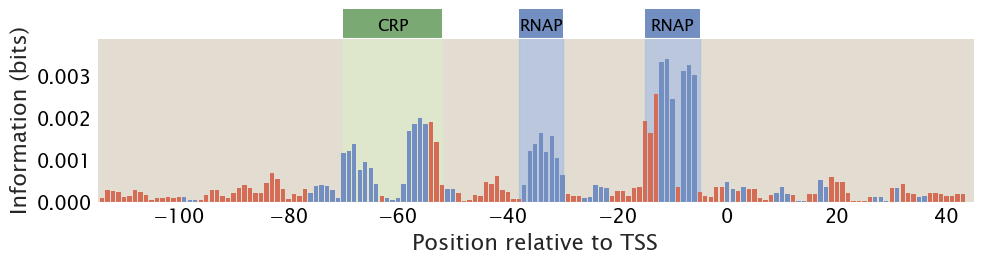

In [9]:
n_NS = len(genome)
n_p = 5000
n_a = 50
ep_wt = -3
ea_wt = -13
e_ap = -10

alpha = 0.3

df = tregs.simulate.sim(promoter, simact_pbound_with_noise, [rnap_site, crp_site], 
                        *[n_NS, n_p, n_a, rnap_emat, crp_emat, ep_wt, ea_wt, e_ap, alpha])

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (-70, -52, 'A', 'CRP')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               annotate_stn=False,
                               outfile='../rebuttal_plots/figR7/simact_lownoise.pdf')

### Double repression

In [10]:
def doublerep_pbound_with_noise(p_seq, r1_seq, r2_seq, n_NS, mean_p, mean_r1, mean_r2,
                     p_emat, r1_emat, r2_emat, 
                     ep_wt, er1_wt, er2_wt, e_int_r1r2,
                     alpha):
    
    n_p_exponent = np.random.normal(np.log(mean_p), alpha * np.log(mean_p), 1)[0]
    n_r1_exponent = np.random.normal(np.log(mean_r1), alpha * np.log(mean_r1), 1)[0]
    n_r2_exponent = np.random.normal(np.log(mean_r2), alpha * np.log(mean_r2), 1)[0]

    n_p = np.exp(n_p_exponent)
    n_r1 = np.exp(n_r1_exponent)
    n_r2 = np.exp(n_r2_exponent)

    w_p = tregs.simulate.get_weight(p_seq, p_emat, e_wt=ep_wt)
    w_r1 = tregs.simulate.get_weight(r1_seq, r1_emat, e_wt=er1_wt)
    w_r2 = tregs.simulate.get_weight(r2_seq, r2_emat, e_wt=er2_wt)

    z = np.zeros(5)
    z[0] = 1
    z[1] = n_p / n_NS * w_p
    z[2] = n_r1 / n_NS * w_r1
    z[3] = n_r2 / n_NS * w_r2
    z[4] = (n_r1 / n_NS * w_r1) * (n_r2 / n_NS * w_r2) * np.exp(-e_int_r1r2)
    pbound = z[1] / np.sum(z)

    return pbound

In [11]:
rep1_site = promoter[(115-50):(115-40)]
rep2_site = promoter[(115+15):(115+25)]
r1_emat = tregs.simulate.generate_emap(rep1_site, fixed=True, fixed_value=1)
r2_emat = tregs.simulate.generate_emap(rep2_site, fixed=True, fixed_value=1)

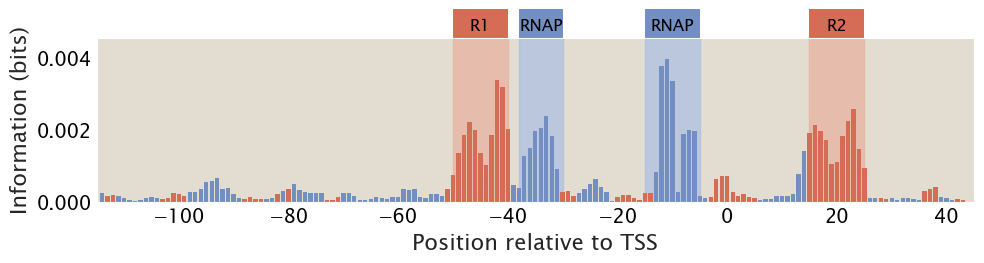

In [12]:
n_NS = len(genome)
ep_wt, er1_wt, er2_wt = -5, -12, -12
e_int = -5
n_p, n_r1, n_r2 = 4600, 15, 15

alpha = 0.3

df = tregs.simulate.sim(promoter, doublerep_pbound_with_noise, [rnap_site, rep1_site, rep2_site],
                        *[n_NS, n_p, n_r1, n_r2, rnap_emat, r1_emat, r2_emat, ep_wt, er1_wt, er2_wt, e_int, alpha],
                        scaling_factor=10**6)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (-50, -40, 'R', 'R1'), (15, 25, 'R', 'R2')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               nbins=2, annotate_stn=False,
                               outfile='../rebuttal_plots/figR7/doublerep_lownoise.pdf')

### Double activation

In [13]:
def doubleact_pbound_with_noise(p_seq, a1_seq, a2_seq, n_NS, mean_p, mean_a1, mean_a2,
                                p_emat, a1_emat, a2_emat, 
                                ep_wt, ea1_wt, ea2_wt, e_int_a1a2, e_int_pa1, e_int_pa2,
                                alpha):
    
    n_p_exponent = np.random.normal(np.log(mean_p), alpha * np.log(mean_p), 1)[0]
    n_a1_exponent = np.random.normal(np.log(mean_a1), alpha * np.log(mean_a1), 1)[0]
    n_a2_exponent = np.random.normal(np.log(mean_a2), alpha * np.log(mean_a2), 1)[0]

    n_p = np.exp(n_p_exponent)
    n_a1 = np.exp(n_a1_exponent)
    n_a2 = np.exp(n_a2_exponent)
    
    w_p = tregs.simulate.get_weight(p_seq, p_emat, e_wt=ep_wt)
    w_a1 = tregs.simulate.get_weight(a1_seq, a1_emat, e_wt=ea1_wt)
    w_a2 = tregs.simulate.get_weight(a2_seq, a2_emat, e_wt=ea2_wt)

    z = np.zeros(8)
    z[0] = 1
    z[1] = n_a1 / n_NS * w_a1
    z[2] = n_a2 / n_NS * w_a2
    z[3] = (n_a1 / n_NS * w_a1) * (n_a2 / n_NS * w_a2) * np.exp(-e_int_a1a2)
    z[4] = n_p / n_NS * w_p
    z[5] = (n_p / n_NS * w_p) * (n_a1 / n_NS * w_a1) * np.exp(-e_int_pa1)
    z[6] = (n_p / n_NS * w_p) * (n_a2 / n_NS * w_a2) * np.exp(-e_int_pa2)
    z[7] = z[5] * (n_a2 / n_NS * w_a2)  * np.exp(-e_int_pa2) * np.exp(-e_int_a1a2)
    pbound = np.sum(z[4:]) / np.sum(z)

    return pbound

In [14]:
act1_site = promoter[(115 - 110 + 15):(115 - 110 + 25)]
act2_site = promoter[(115 - 110 + 35):(115 - 110 + 45)]
a1_emat = tregs.simulate.generate_emap(act1_site, fixed=True, fixed_value=1)
a2_emat = tregs.simulate.generate_emap(act2_site, fixed=True, fixed_value=1)

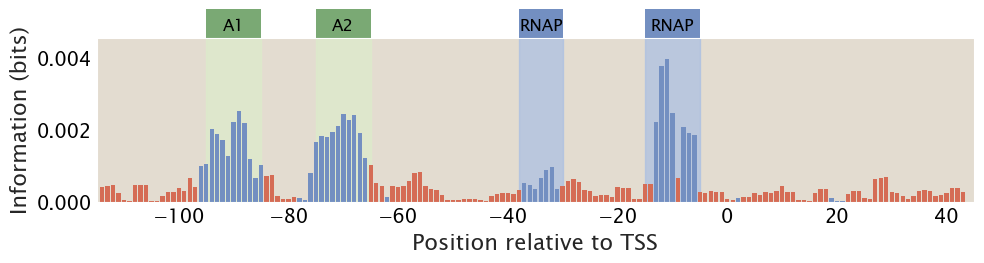

In [15]:
n_NS = len(genome)
ep_wt, ea1_wt, ea2_wt = -2, -7, -7
e_int_pa1, e_int_pa2, e_int_a1a2 = -7, -7, -7
mean_p, mean_a1, mean_a2 = 4600, 50, 50

alpha = 0.3

df = tregs.simulate.sim(promoter, doubleact_pbound_with_noise, [rnap_site, act1_site, act2_site],
                        *[n_NS, mean_p, mean_a1, mean_a2, rnap_emat, a1_emat, a2_emat, ep_wt, ea1_wt, ea2_wt, e_int_pa1, e_int_pa2, e_int_a1a2, alpha], scaling_factor=100)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (-95, -85, 'A', 'A1'), (-75, -65, 'A', 'A2')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               nbins=2, annotate_stn=False,
                               outfile='../rebuttal_plots/figR7/doubleact_lownoise.pdf')

### Repression-activation

In [16]:
def repact_pbound_with_noise(p_seq, r_seq, a_seq, n_NS, mean_p, mean_r, mean_a,
                            p_emat, r_emat, a_emat,
                            ep_wt, er_wt, ea_wt, e_int_pa, alpha):
    
    n_p_exponent = np.random.normal(np.log(mean_p), alpha * np.log(mean_p), 1)[0]
    n_a_exponent = np.random.normal(np.log(mean_a), alpha * np.log(mean_a), 1)[0]
    n_r_exponent = np.random.normal(np.log(mean_r), alpha * np.log(mean_r), 1)[0]

    n_p = np.exp(n_p_exponent)
    n_a = np.exp(n_a_exponent)
    n_r = np.exp(n_r_exponent)

    w_p = tregs.simulate.get_weight(p_seq, p_emat, e_wt=ep_wt)
    w_r = tregs.simulate.get_weight(r_seq, r_emat, e_wt=er_wt)
    w_a = tregs.simulate.get_weight(a_seq, a_emat, e_wt=ea_wt)

    z = np.zeros(5)
    z[0] = 1
    z[1] = n_p / n_NS * w_p
    z[2] = n_r / n_NS * w_r
    z[3] = n_a / n_NS * w_a
    z[4] = (n_p / n_NS * w_p) * (n_a / n_NS * w_a) * np.exp(-e_int_pa)
    
    return (z[1] + z[4]) / np.sum(z)

In [17]:
act_site = promoter[(115 - 110 + 40):(115 - 110 + 55)]
rep_site = promoter[(115+5):(115+20)]

act_emat = tregs.simulate.generate_emap(act_site, fixed=True, fixed_value=1)
rep_emat = tregs.simulate.generate_emap(rep_site, fixed=True, fixed_value=1)

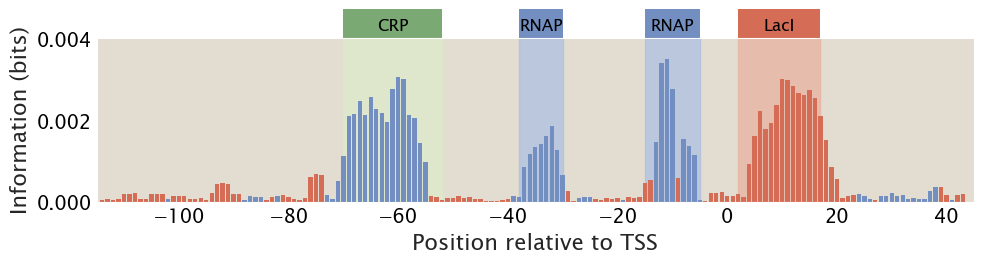

In [18]:
n_NS = len(genome)
ep_wt, er_wt, ea_wt = -2, -15, -12
e_int = -8
n_p, n_r, n_a = 4600, 50, 50

alpha = 0.3

df = tregs.simulate.sim(promoter, repact_pbound_with_noise, [rnap_site, rep_site, act_site],
                        *[n_NS, n_p, n_r, n_a, rnap_emat, rep_emat, act_emat, ep_wt, er_wt, ea_wt, e_int, alpha], scaling_factor=10*6)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (-70, -52, 'A', 'CRP'), (2, 17, 'R', 'LacI')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               nbins=2, annotate_stn=False,
                               outfile='../rebuttal_plots/figR7/repact_lownoise.pdf')